# MS028 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS028'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 130 x 1097024 (2142.6 s), ~1.06 GB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1097024 (2142.6 s), ~8.4 MB, data loaded>

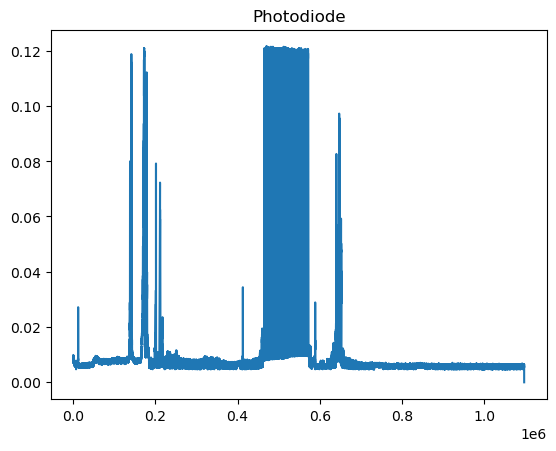

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LAglT1,mAmyg_L,-22.353151,11.990105,-12.842655,-24.030008,-2.466548,-21.004349,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN,NaN
1,LAglT2,lAmyg_L,-27.152578,11.990105,-11.243587,-29.338226,-2.282588,-19.243495,Gray,Left Ent entorhinal area,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN,NaN
2,LAglT3,Unknown,-31.952006,12.389775,-10.044287,-34.646184,-1.732659,-18.001756,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
3,LAglT4,vId/vIg_L,-36.751433,12.389775,-8.445219,-39.885009,-1.486931,-16.129432,Gray,Left PIns posterior insula,Area Id1,L Superior Temporal Gyrus,L INS,Left superior temporal gyrus A,NaN,NaN
4,LAglT5,A38l_L,-41.550861,12.789446,-7.245918,-45.108698,-0.767422,-14.632926,Gray,Left PP planum polare,Unknown,L Superior Temporal Gyrus,L STG,Left superior temporal gyrus A,NaN,Borderline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,RmOlF9,A44op_R,35.639932,35.170976,11.942894,39.015475,30.366030,0.328881,Gray,Right TrIFG triangular part of the inferior fr...,Unknown,R IFG (p Triangularis),R IFG,Right anterior pars triangularis B,NaN,NaN
162,uLAglT,rHipp_L,-17.953676,11.190765,-14.041956,-19.136886,-3.331668,-22.148985,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN,NaN
163,uLmOlF,A13_L,-7.554916,38.768008,-10.044287,-8.831674,27.220768,-22.979829,Gray,Left GRe gyrus rectus,Area Fo2,L Rectal Gyrus,L OrG,Left frontal orbital 5 A,NaN,NaN
164,uRAglT,mAmyg_R,18.042031,7.993403,-12.043121,19.030036,-5.166208,-20.077131,Gray,Right Amygdala,Amygdala (SF),R ParaHippocampal Gyrus,R Amyg,Right amygdala superior,NaN,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,147.0,loss,415.248181,415.261651,418.478325,418.486410,3.216674,-0.6,-1.90,...,-0.884158,0.001966,9.980344e-01,0.000000,0.655426,0.655426,0.000000,0.000000,0.655426,0.655426
1,2,49.0,mix,425.428719,425.429475,427.623831,429.640132,2.194356,0.0,-1.50,...,-0.581264,1.000000,4.986336e-07,0.581264,0.000000,2.107938,0.000000,0.000000,2.689202,2.107938
2,3,104.0,loss,434.667298,434.668050,438.568198,438.573047,3.900148,-0.2,-0.44,...,-0.065962,0.421298,5.787019e-01,0.000000,-0.032565,-0.032565,-0.032565,-0.032565,0.000000,0.000000
3,4,77.0,gain,448.180423,448.181139,449.778751,451.794099,1.597613,0.4,0.00,...,0.000000,0.994992,5.008372e-03,0.000000,0.000000,0.556707,0.000000,0.000000,0.753460,0.556707
4,5,75.0,gain,455.882891,455.889917,458.640682,460.657221,2.750766,0.4,0.00,...,0.000000,0.942591,5.740941e-02,0.000000,0.000000,0.294409,0.000000,0.000000,0.491163,0.294409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,41.0,mix,2066.566243,2066.573045,2068.188452,2070.205437,1.615407,0.0,-0.80,...,-0.190537,0.931467,6.853270e-02,-0.465065,-0.655601,-0.190537,-0.655601,-0.190537,0.000000,0.000000
146,147,116.0,loss,2075.402618,2075.409942,2079.715767,2079.723540,4.305825,-0.3,-0.84,...,-0.207767,0.207625,7.923748e-01,0.000000,0.140901,0.140901,0.000000,0.000000,0.140901,0.140901
147,148,85.0,gain,2089.111040,2089.117723,2090.110714,2092.126862,0.992990,0.5,0.00,...,0.000000,0.984972,1.502819e-02,0.000000,0.000000,0.440040,0.000000,0.000000,0.732371,0.440040
148,149,95.0,gain,2096.835060,2096.841660,2097.805971,2099.822997,0.964311,0.6,0.00,...,0.000000,0.996991,3.008699e-03,-1.014518,-1.014518,-0.403987,-1.014518,-0.403987,0.000000,0.000000


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [22]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=1.2)

3 blocks
...

found matches for 15 of 50 pulses


## Make epochs

In [23]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [24]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [25]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [26]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 18292 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 19500 out of 19500 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 18950 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 19500 out of 19500 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

In [27]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~114.5 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~190.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [28]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [29]:
epochs_all_evs[event].metadata

,lcmmm6,lcmmm14,rcmmm10,rcmmm12,rcmmm14,laips14,laips15,laips16,rims15,rims16,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.0,1.30,1.30,-0.884158,-0.228732
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.375,1.875,0.00,2.25,0.00,0.0,3.75,2.25,1.526675,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.20,-0.20,-0.20,-0.2,0.00,0.00,-0.065962,-0.032565
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.630,0.630,0.00,0.86,0.00,0.0,1.26,0.86,0.753460,0.196754
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.495,0.495,0.00,0.59,0.00,0.0,0.99,0.59,0.491163,0.196754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.080,-0.880,-1.76,-0.80,-1.76,-0.8,0.00,0.00,0.274528,0.000000
146,[313],NaN,NaN,NaN,NaN,[313],[313],[313],NaN,NaN,...,0.000,0.000,-0.30,-0.30,0.00,0.0,0.54,0.54,-0.207767,-0.066865
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.620,0.620,0.00,0.74,0.00,0.0,1.24,0.74,0.732371,0.292330
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.745,-0.745,-1.49,-0.60,-1.49,-0.6,0.00,0.00,1.014518,0.403987


### Save epoched data

In [30]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)